<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/Semantic_segmentation%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Сегментация изображений</b></h3> 





---


1. Используем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>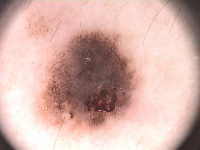</td><td>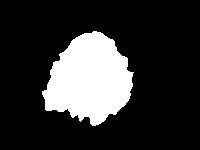</td></tr></table>

Это фотографии двух типов **поражений кожи:** меланома и родинки.
Мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# Подключает к ноутбуку наш диск гугл-драйв
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Выясняем, как называется наш корневой каталог
!ls /content/gdrive/

MyDrive


In [ ]:
# Убедимся, что ранее загруженный архив виден
!ls -l /content/gdrive/MyDrive/PH2Dataset.rar

-rw------- 1 root root 161895206 Apr 15 13:50 /content/gdrive/MyDrive/PH2Dataset.rar


In [ ]:
# Распаковываем архив
!pip install patool

     |████████████████████████████████| 77 kB 3.3 MB/s 


In [ ]:
import patoolib
patoolib.extract_archive("/content/gdrive/MyDrive/PH2Dataset.rar", outdir="/content")

patool: Extracting /content/gdrive/MyDrive/PH2Dataset.rar ...
patool: running /usr/bin/unrar x -- /content/gdrive/MyDrive/PH2Dataset.rar
patool:     with cwd='/content'
patool: ... /content/gdrive/MyDrive/PH2Dataset.rar extracted to `/content'.


'/content'

Стуктура датасета следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

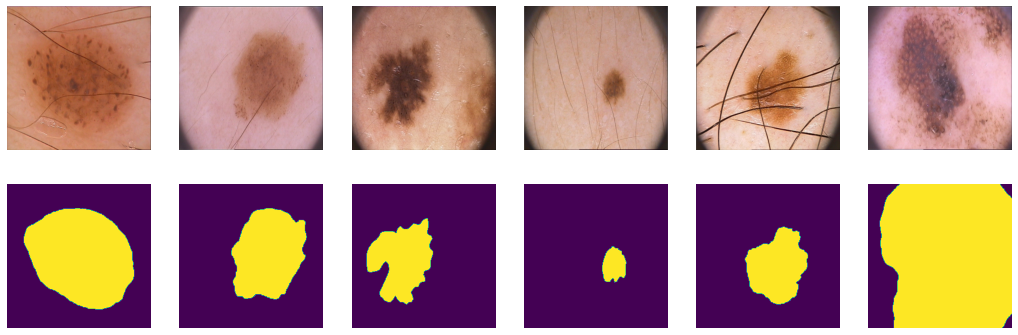

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

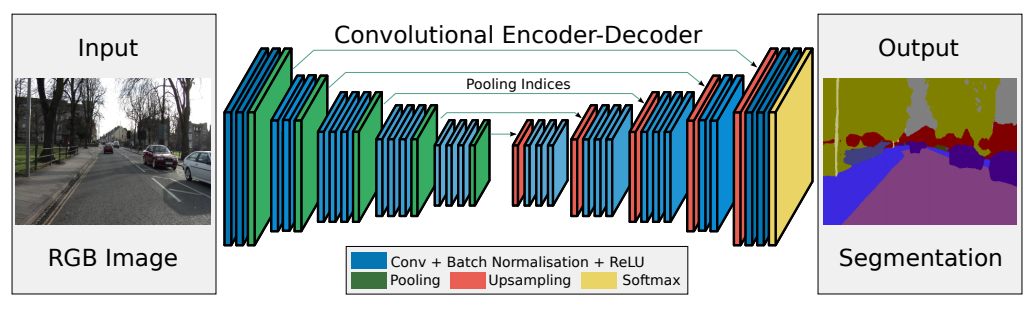

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Реализую архитектуру по картинке: encoder аналогичен сверточной части VGG-16, decoder - симметричен ему.

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
      
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # return_indices=True для сохранения индексов взятых элементов (чтобы потом использовать их для MaxUnpool)
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 128 -> 64

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 64 -> 32

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 32 -> 16

        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool5 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 32 -> 16

        # decoder (upsampling)
        self.upsample5 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32

        self.dec_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample4 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 32 -> 64

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e1, indices1 = self.pool1(self.enc_conv1(x))   # indices - индексы, возвращаемые MaxPool
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))
        e4, indices4 = self.pool4(self.enc_conv4(e3))
        e5, indices5 = self.pool5(self.enc_conv5(e4))

        # decoder
        d5 = self.dec_conv5(self.upsample4(e5, indices5))
        d4 = self.dec_conv4(self.upsample4(d5, indices4))
        d3 = self.dec_conv3(self.upsample3(d4, indices3))
        d2 = self.dec_conv2(self.upsample2(d3, indices2))
        d1 = self.dec_conv1(self.upsample1(d2, indices1))
        return d1

## Метрика

Используем следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs[:,0,:,:].squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_pred*y_real + torch.log(1 + torch.exp(-y_pred)))

## Тренировка 

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    best_score = 0.0
    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        train_score = score_model(model, iou_pytorch, data_tr)

        # show intermediate results
        model.eval()  # testing mode
        with torch.set_grad_enabled(False):
            Y_hat = model(X_val.to(device)).detach().to('cpu')
            val_loss = loss_fn(Y_val, Y_hat)
            val_score = score_model(model, iou_pytorch, data_val)

        history.append((avg_loss, train_score, val_loss, val_score))

        # если достиглось лучшее качество, то запомним веса модели
        if val_score > best_score:
            best_score = val_score
            best_model_wts = model.state_dict()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    model.load_state_dict(best_model_wts)
    return model, history, best_score

## Инференс 



In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = Y_pred > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

## Обучение


In [ ]:
model = SegNet().to(device)

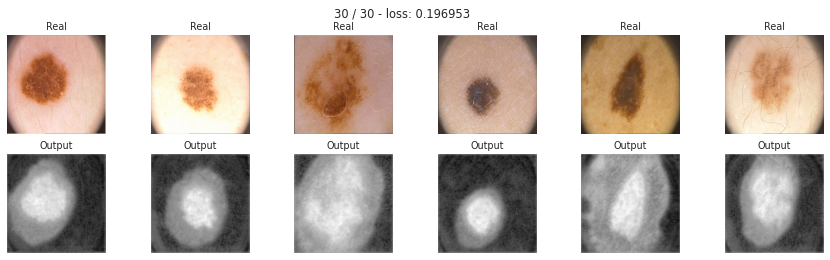

In [ ]:
sns.set(font_scale=0.8)
max_epochs = 30
optim = torch.optim.Adam(model.parameters())
best_model, history, best_score_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
#torch.save(best_model.state_dict(), 'model_params2.pth')

In [ ]:
#model.load_state_dict(torch.load('model_params.pth'))

In [ ]:
loss_bce, score_bce, val_loss_bce, val_score_bce = zip(*history)

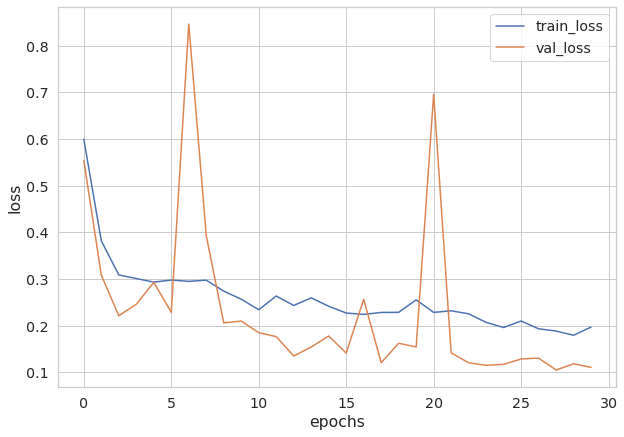

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_bce).to('cpu'), label="train_loss")
plt.plot(val_loss_bce, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

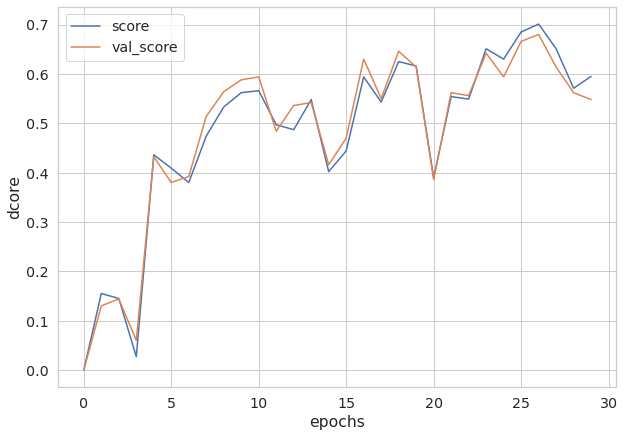

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(score_bce, label="score")
plt.plot(torch.Tensor(val_score_bce).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("dcore")
plt.legend()
plt.show()

Не переобучается ли модель?
Эффект переобучения присутствует


## Дополнительные функции потерь 

 В данном разделе имплементируем две функции потерь:
 DICE и Focal loss. 



**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$


In [ ]:
def dice_loss(y_real, y_pred):
    epsilon = 1e-6
    num = 2 * torch.sum(y_real * torch.sigmoid(y_pred))
    den = torch.sum(y_real + torch.sigmoid(y_pred))
    res = 1 - num/(den+epsilon)/(256**2)
    return torch.mean(res) 

Проводим тестирование:

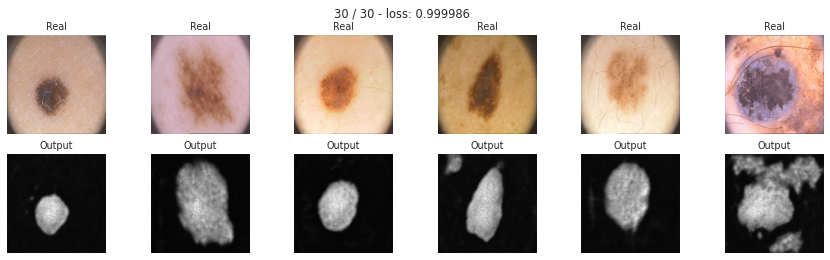

In [ ]:
sns.set(font_scale=0.8)
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters())
history, best_score_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_dice, score_dice, val_loss_dice, val_score_dice = zip(*history)

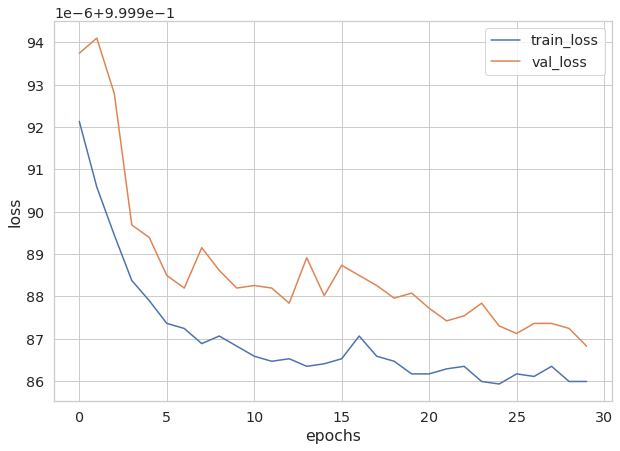

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_dice).to('cpu'), label="train_loss")
plt.plot(val_loss_dice, label="val_loss", )
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

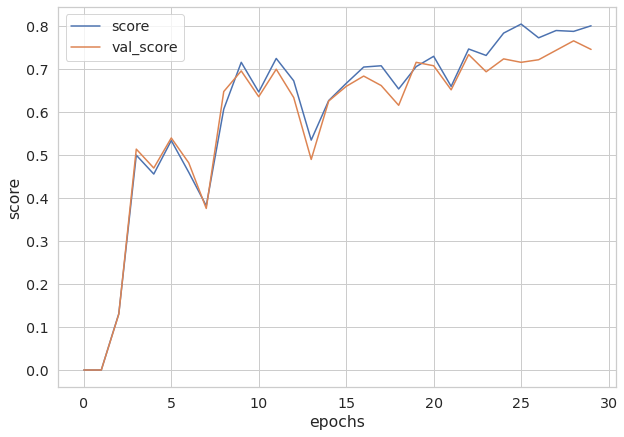

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(score_dice, label="score")
plt.plot(torch.Tensor(val_score_dice).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** по отношению к классу **меньшинства**. Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    res =((1-y_pred)**gamma) * y_real * torch.log(y_pred+eps) + (1-y_real) * torch.log(1-y_pred+eps)
    return -torch.mean(res)


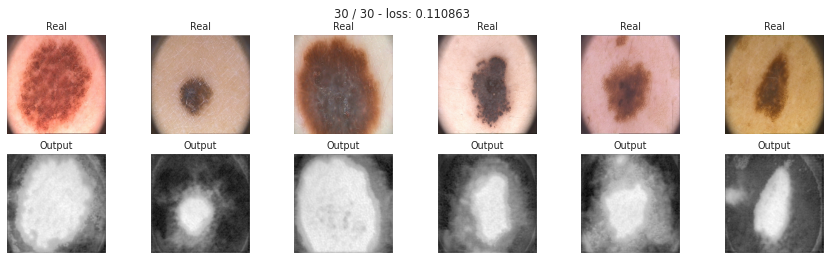

In [ ]:
sns.set(font_scale=0.8)
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_focal.parameters())
best_model, history, best_score_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_focal, score_focal, val_loss_focal, val_score_focal = zip(*history)

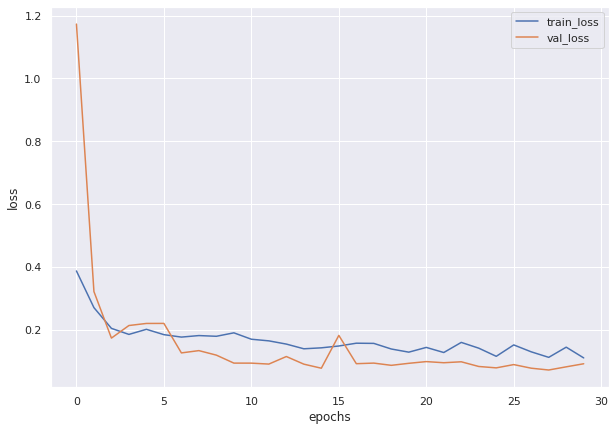

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_focal).to('cpu'), label="train_loss")
plt.plot(val_loss_focal, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

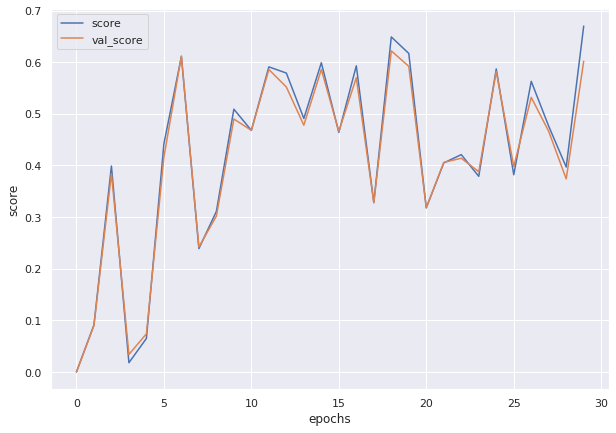

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 7))
plt.plot(score_focal, label="score")
plt.plot(torch.Tensor(val_score_focal).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов

Какие варианты:

1) Учесть Total Variation <br>
2) Lova <br>
3) BCE но с Soft Targets <br>
4) Любой другой <br>

Я остановился на [SSIM loss](https://tandon-a.github.io/CycleGAN_ssim/):



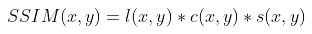

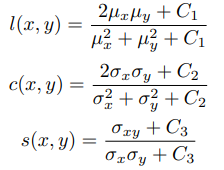

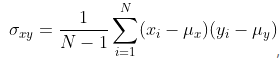

Функционал определяется, как (1-SSIM)

In [ ]:
def SSIM(y_real, y_pred, C1 = 1e-3, C2 = 1e-3, C3 = 1e-3/2):
  l = (2*torch.mean(y_real)*torch.mean(y_pred) + C1)/(torch.mean(y_real)**2 + torch.mean(y_pred)**2 + C1)
  c = (2*torch.std(y_real)*torch.std(y_pred) + C2)/(torch.std(y_real)**2 + torch.std(y_pred)**2 + C2)
  sigm_xy = torch.mean((y_real - torch.mean(y_real)) * (y_pred - torch.mean(y_pred)))
  s = (sigm_xy + C3)/(torch.std(y_real)*torch.std(y_pred) + C3)
  return 1-l*c*s


In [ ]:
model = SegNet().to(device)

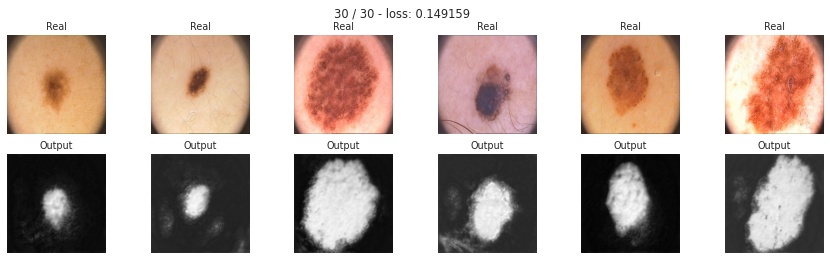

In [ ]:
sns.set(font_scale=0.8)
max_epochs = 30
optim = torch.optim.Adam(model.parameters())
best_model, history, best_score_SSIM = train(model, optim, SSIM, max_epochs, data_tr, data_val)

In [ ]:
loss_SSIM, score_SSIM, val_loss_SSIM, val_score_SSIM = zip(*history)

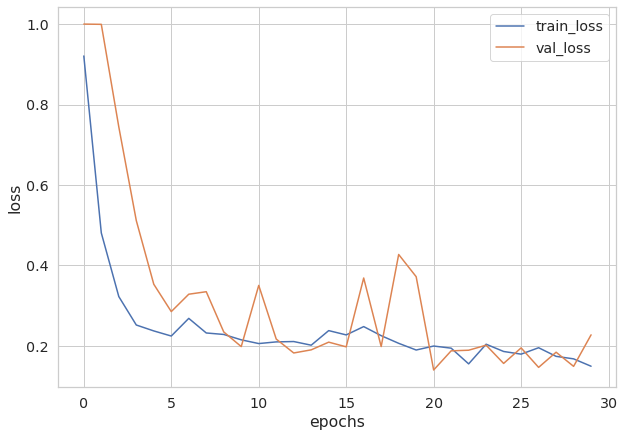

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_SSIM).to('cpu'), label="train_loss")
plt.plot(val_loss_SSIM, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

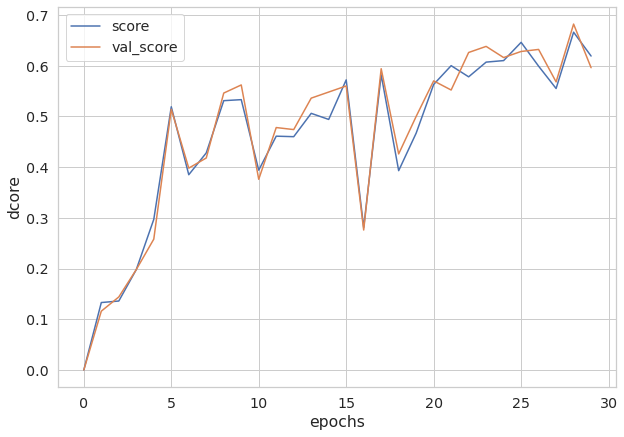

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(score_SSIM, label="score")
plt.plot(torch.Tensor(val_score_SSIM).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("dcore")
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------

# U-Net 

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

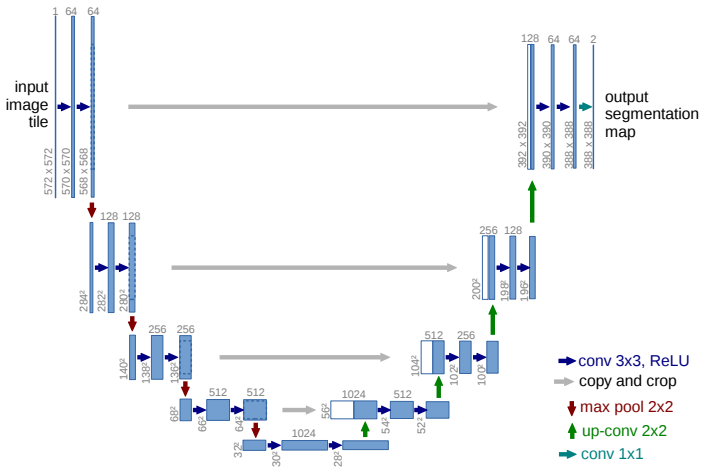

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # return_indices=True для сохранения индексов взятых элементов (чтобы потом использовать их для MaxUnpool)
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 128 -> 64

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 64 -> 32

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 32 -> 64

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e1, indices1 = self.pool1(self.enc_conv1(x))   # indices - индексы, возвращаемые MaxPool
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))
        e4, indices4 = self.pool4(self.enc_conv4(e3))

        # bottleneck
        b = self.bottleneck(e4)

        # decoder
        s = torch.cat((self.enc_conv4(e3), self.upsample4(b, indices4)), dim=1)
        d4 = self.dec_conv4(s)
        
        s = torch.cat((self.enc_conv3(e2), self.upsample3(d4, indices3)), dim=1)
        d3 = self.dec_conv3(s)

        s = torch.cat((self.enc_conv2(e1), self.upsample2(d3, indices2)), dim=1)
        d2 = self.dec_conv2(s)

        s = torch.cat((self.enc_conv1(x), self.upsample1(d2, indices1)), dim=1)
        d1 = self.dec_conv1(s)
        return d1

In [ ]:
unet_model = UNet().to(device)

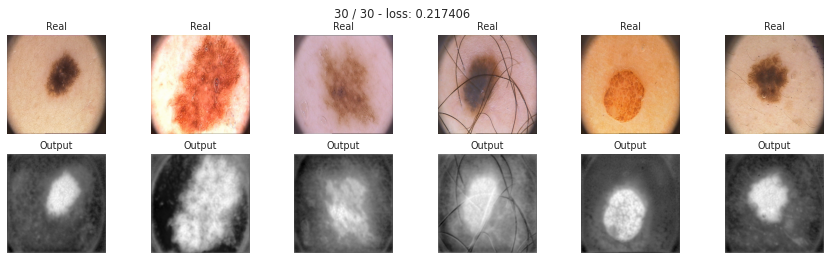

In [ ]:
sns.set(font_scale=0.8)
best_model, history, best_score_unet = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 30, data_tr, data_val)

In [ ]:
loss_unet, score_unet, val_loss_unet, val_score_unet = zip(*history)

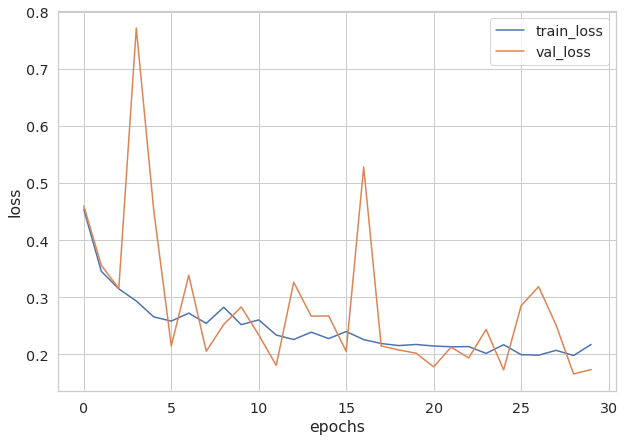

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_unet).to('cpu'), label="train_loss")
plt.plot(val_loss_unet, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

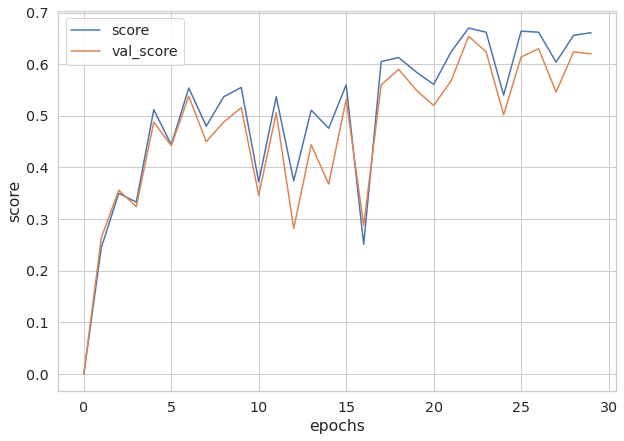

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(score_unet, label="score")
plt.plot(torch.Tensor(val_score_unet).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

Новая модель путем изменения типа пулинга:

Down-sampling

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.Conv2d(64, 64, kernel_size=2, stride=2)

Up-Sampling

        upsample = nn.Upsample(32)
        nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2))


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # return_indices=True для сохранения индексов взятых элементов (чтобы потом использовать их для MaxUnpool)
        self.pool1 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool2 = nn.Conv2d(128, 128, kernel_size=2, stride=2)  # 128 -> 64

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool3 = nn.Conv2d(256, 256, kernel_size=2, stride=2)  # 64 -> 32

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.Conv2d(512, 512, kernel_size=2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)  # 32 -> 64

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e1 = self.pool1(self.enc_conv1(x))   # indices - индексы, возвращаемые MaxPool
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
        e4 = self.pool4(self.enc_conv4(e3))

        # bottleneck
        b = self.bottleneck(e4)

        # decoder
        s = torch.cat((self.enc_conv4(e3), self.upsample4(b)), dim=1)
        d4 = self.dec_conv4(s)
        
        s = torch.cat((self.enc_conv3(e2), self.upsample3(d4)), dim=1)
        d3 = self.dec_conv3(s)

        s = torch.cat((self.enc_conv2(e1), self.upsample2(d3)), dim=1)
        d2 = self.dec_conv2(s)

        s = torch.cat((self.enc_conv1(x), self.upsample1(d2)), dim=1)
        d1 = self.dec_conv1(s)
        return d1

In [ ]:
unet2_model = UNet2().to(device)


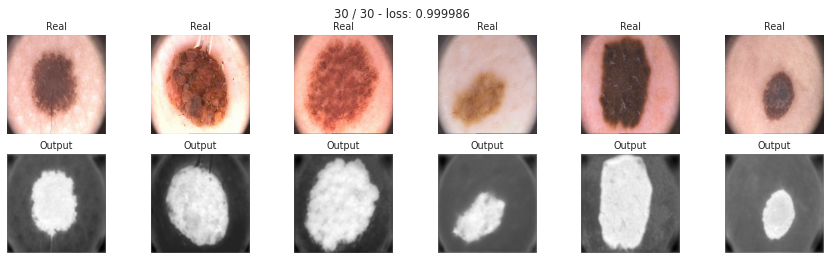

In [ ]:
sns.set(font_scale=0.8)
best_model, history, best_score = train(unet2_model, torch.optim.Adam(unet2_model.parameters()), dice_loss, 30, data_tr, data_val)

In [ ]:
loss_unet2, score_unet2, val_loss_unet2, val_score_unet2 = zip(*history)

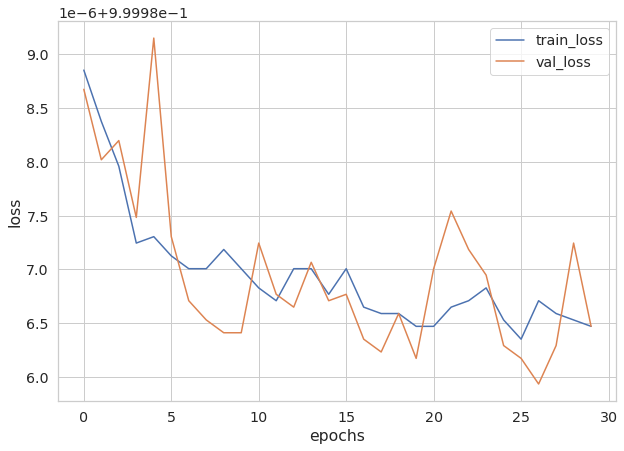

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(torch.Tensor(loss_unet2).to('cpu'), label="train_loss")
plt.plot(val_loss_unet2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

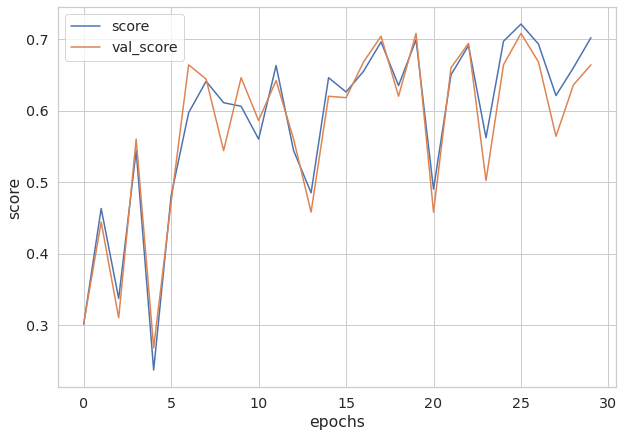

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(10, 7))
plt.plot(score_unet2, label="score")
plt.plot(torch.Tensor(val_score_unet2).to('cpu'), label="val_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

# Отчет (6 баллов): 


## Анализ графиков score

После обучения 4 одинаковых моделей SegNet с 4 разными loss-функциями попробуем определить, какая из них показала себя лучше.
Графики 

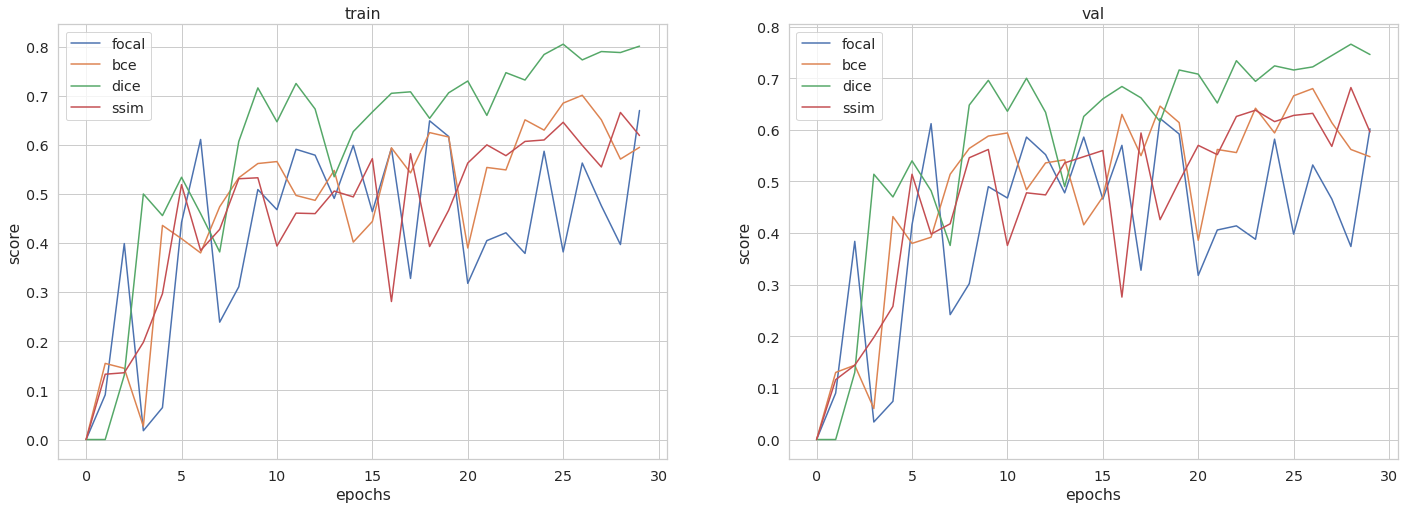

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(1,2, figsize=(24, 8))

ax[0].plot(score_focal, label="focal")
ax[0].plot(score_bce, label="bce")
ax[0].plot(score_dice, label="dice")
ax[0].plot(score_SSIM, label="ssim")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(val_score_focal, label="focal")
ax[1].plot(val_score_bce, label="bce")
ax[1].plot(val_score_dice, label="dice")
ax[1].plot(val_score_SSIM, label="ssim")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("score")
ax[1].legend()

plt.show()

##Проанализируем отнормированные графики loss

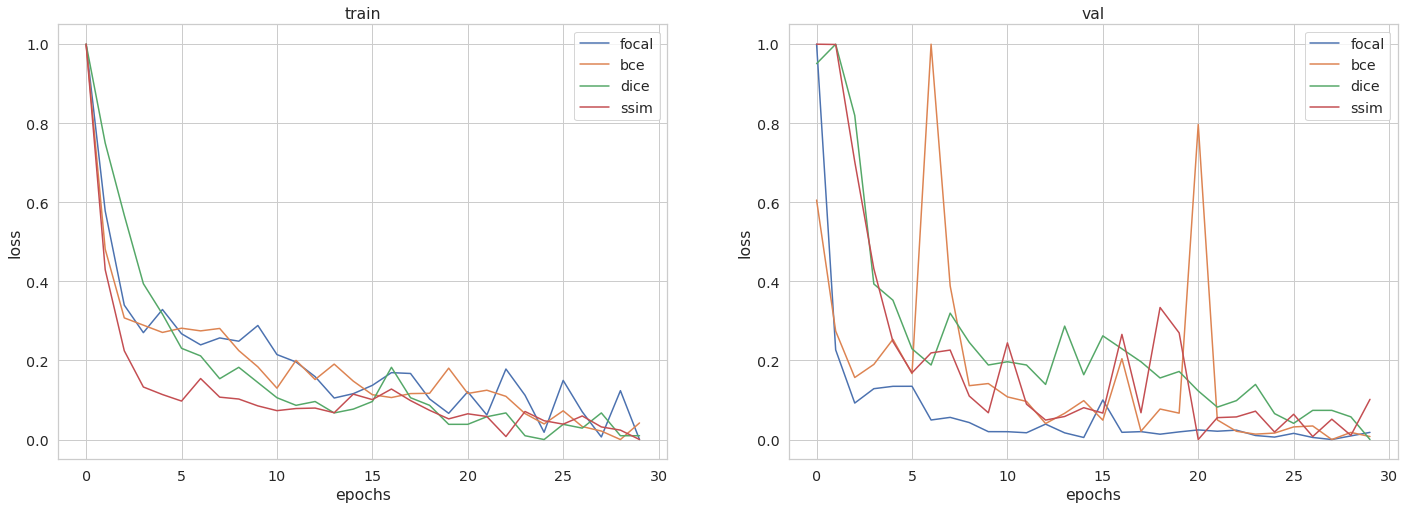

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24, 8))

loss_focal = torch.Tensor(loss_focal).to('cpu')
loss_bce = torch.Tensor(loss_bce).to('cpu')
loss_dice = torch.Tensor(loss_dice).to('cpu')
loss_SSIM = torch.Tensor(loss_SSIM).to('cpu')

val_loss_focal = torch.Tensor(val_loss_focal)
val_loss_bce = torch.Tensor(val_loss_bce)
val_loss_dice = torch.Tensor(val_loss_dice)
val_loss_SSIM = torch.Tensor(val_loss_SSIM).to('cpu')

ax[0].plot((loss_focal-torch.min(loss_focal))/(torch.max(loss_focal)-torch.min(loss_focal)), label="focal")
ax[0].plot((loss_bce-torch.min(loss_bce))/(torch.max(loss_bce)-torch.min(loss_bce)), label="bce")
ax[0].plot((loss_dice-torch.min(loss_dice))/(torch.max(loss_dice)-torch.min(loss_dice)), label="dice")
ax[0].plot((loss_SSIM-torch.min(loss_SSIM))/(torch.max(loss_SSIM)-torch.min(loss_SSIM)), label="ssim")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot((val_loss_focal-torch.min(val_loss_focal))/(torch.max(val_loss_focal)-torch.min(val_loss_focal)), label="focal")
ax[1].plot((val_loss_bce-torch.min(val_loss_bce))/(torch.max(val_loss_bce)-torch.min(val_loss_bce)), label="bce")
ax[1].plot((val_loss_dice-torch.min(val_loss_dice))/(torch.max(val_loss_dice)-torch.min(val_loss_dice)), label="dice")
ax[1].plot((val_loss_SSIM-torch.min(val_loss_SSIM))/(torch.max(val_loss_SSIM)-torch.min(val_loss_SSIM)), label="ssim")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].legend()

plt.show()

## Итог по функциям ошибки

1. Первое, что бросается в глаза - сильные колебания функции потерь и оценочной функции. Причина, вероятно, в маленьком batch_size = 10, который пришлось сделать таким, чтобы в среде хватало памяти. Помимо этого может иметь место вычислительная нестабильность функций. 
2. Стоить отметить, что разные функции потерь демонстрируют разное поведение:
- BCE-loss плохо показывает себя в силу очень существенных колебаний значений функции в процессе обучения как на трейне, так и на валидации. В следствие этого колебания наблюдаются и на оценочной метрике. Однако данная функция имеет тенденцию к сходимости и вполне подходит для данной задачи. 
- Focal-loss выглядит более стабильно на графике, однако по оценочной метрике можно сделать вывод, что эта функция ошибки ведет себя хуже, чем BCE. Я бы сделал вывод, что данная функция не подходит для задачи. 
- Dice-loss определяет стабильный процесс обучения и отлично сходится. Это видно как на графике ошибки, так и на графике оценочной метрики. Помимо этого, с этой функцией ошибки сеть учится лучше и быстрее. Таким образом, для данной задачи эта функция ошибки является наиболее подходящей и вычислительно стабильной, поэтому в UNet я использую именно ее.
- SSIM-loss определяет стабильный процесс обучения и отлично сходится, и в этом схожа с Dice-loss, однако с ней колебания оценочной функции сильнее и score растет медленнее, а значит и учиться надо дольше, чтобы достичь лучшего результата. Данная функция ошибки тоже вполне подходит для решения нашей задачи.

Построим таблицу с лучшими валидационными скорами, которые были получены в процессе обучения:

In [ ]:
import pandas as pd

scores = pd.DataFrame({'loss': ['BCE', 'Focal', 'Dice', 'SSIM'], 'best_validation_score': [best_score_bce, best_score_focal, best_score_dice, best_score_SSIM]})
display(scores)

,loss,best_validation_score
0,BCE,0.680
1,Focal,0.622
2,Dice,0.766
3,SSIM,0.682


Как видно, Dice-loss за 30 эпох обучилась лучше всех

## UNet1

Сравним результат SegNet и UNet

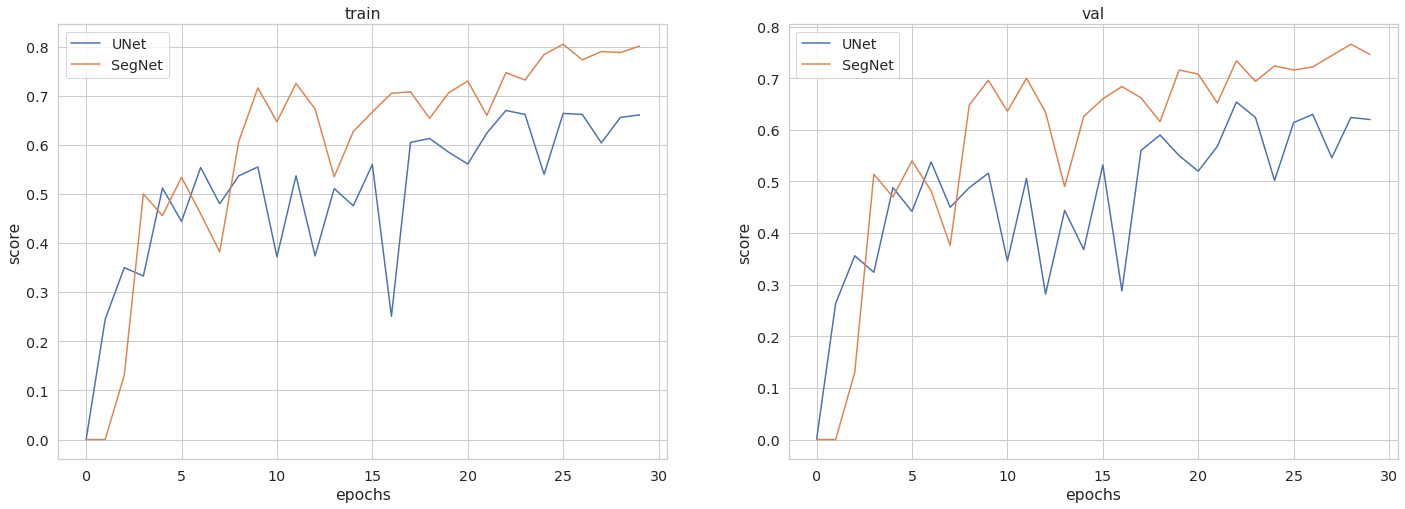

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(1,2, figsize=(24, 8))

ax[0].plot(score_unet, label="UNet")
ax[0].plot(score_dice, label="SegNet")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(val_score_unet, label="UNet")
ax[1].plot(val_score_dice, label="SegNet")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("score")
ax[1].legend()

plt.show()

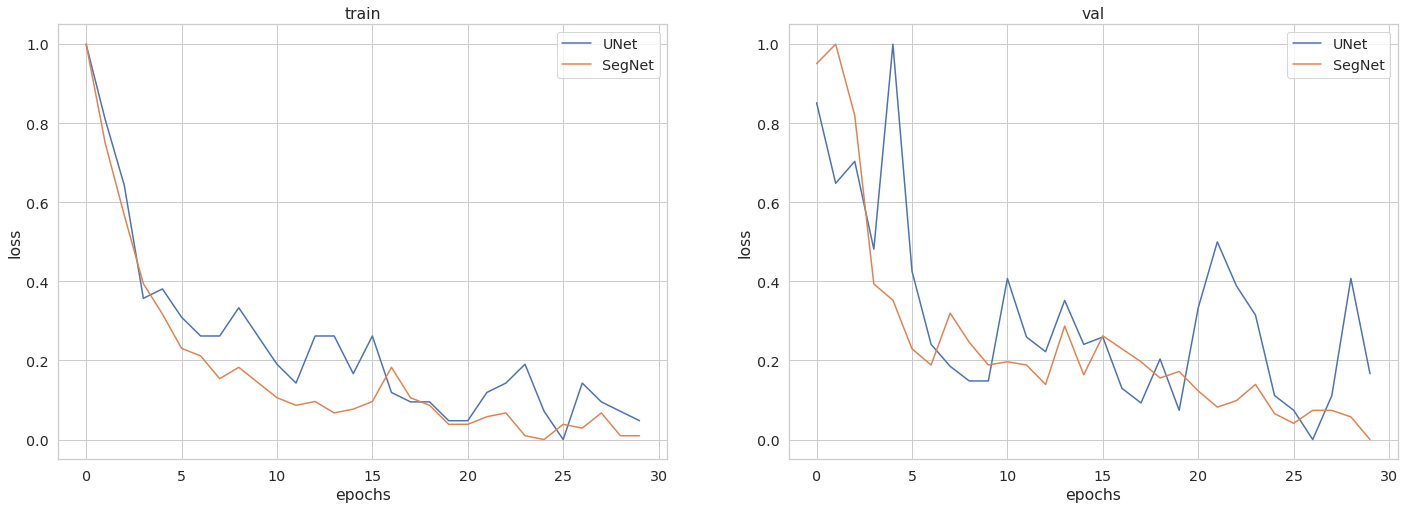

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24, 8))

loss_unet = torch.Tensor(loss_unet).to('cpu')
loss_dice = torch.Tensor(loss_dice).to('cpu')

val_loss_unet = torch.Tensor(val_loss_unet)
val_loss_dice = torch.Tensor(val_loss_dice)

ax[0].plot((loss_unet-torch.min(loss_unet))/(torch.max(loss_unet)-torch.min(loss_unet)), label="UNet")
ax[0].plot((loss_dice-torch.min(loss_dice))/(torch.max(loss_dice)-torch.min(loss_dice)), label="SegNet")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot((val_loss_unet-torch.min(val_loss_unet))/(torch.max(val_loss_unet)-torch.min(val_loss_unet)), label="UNet")
ax[1].plot((val_loss_dice-torch.min(val_loss_dice))/(torch.max(val_loss_dice)-torch.min(val_loss_dice)), label="SegNet")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].legend()

plt.show()

Как видим, в процессе обучения эти две сети ведут себя очень похожим образом. Единственная разница в том, что UNet обучается медленнее из-за бОльшего числа параметров.

## UNet2

Сравним результат SegNet и UNet2

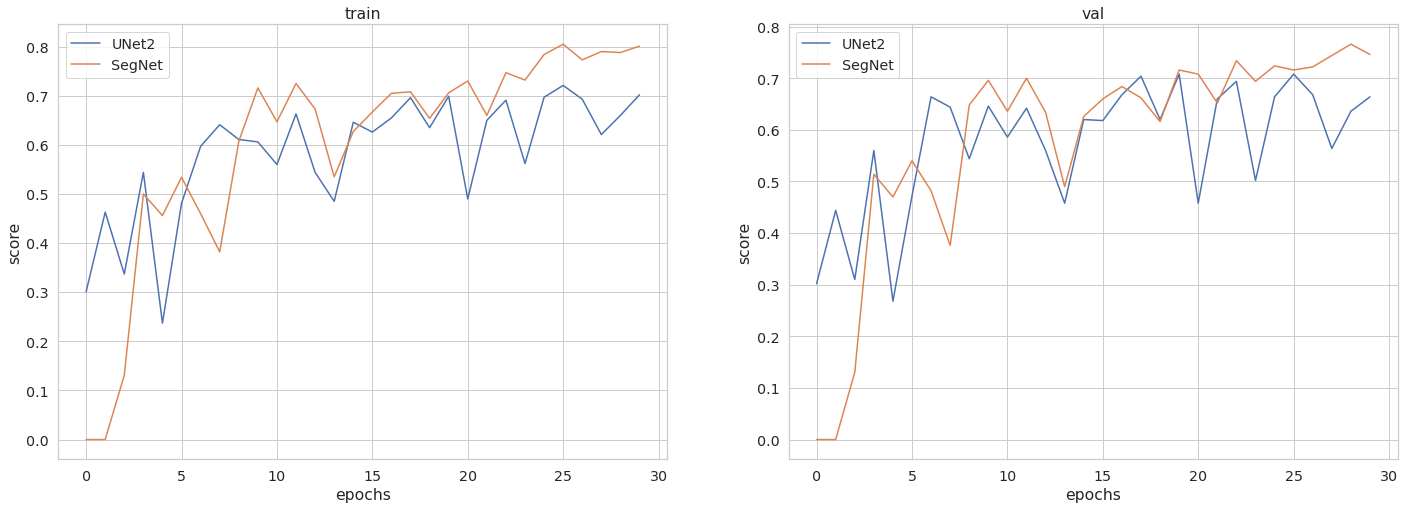

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(1,2, figsize=(24, 8))

ax[0].plot(score_unet2, label="UNet2")
ax[0].plot(score_dice, label="SegNet")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(val_score_unet2, label="UNet2")
ax[1].plot(val_score_dice, label="SegNet")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("score")
ax[1].legend()

plt.show()

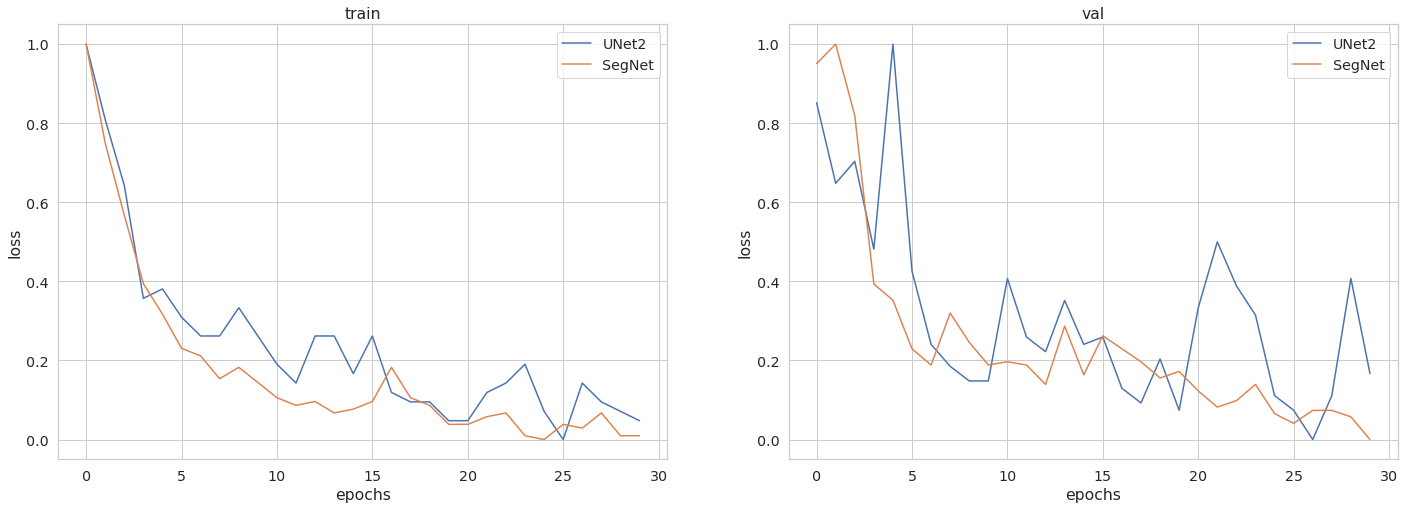

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(24, 8))

loss_unet2 = torch.Tensor(loss_unet2).to('cpu')
loss_dice = torch.Tensor(loss_dice).to('cpu')

val_loss_unet2 = torch.Tensor(val_loss_unet2)
val_loss_dice = torch.Tensor(val_loss_dice)

ax[0].plot((loss_unet2-torch.min(loss_unet2))/(torch.max(loss_unet2)-torch.min(loss_unet2)), label="UNet2")
ax[0].plot((loss_dice-torch.min(loss_dice))/(torch.max(loss_dice)-torch.min(loss_dice)), label="SegNet")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot((val_loss_unet2-torch.min(val_loss_unet2))/(torch.max(val_loss_unet2)-torch.min(val_loss_unet2)), label="UNet2")
ax[1].plot((val_loss_dice-torch.min(val_loss_dice))/(torch.max(val_loss_dice)-torch.min(val_loss_dice)), label="SegNet")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].legend()

plt.show()

Теперь UNet показал результат практически 1 в 1 схожий с SigNet 

## Итог по UNet

Сравним UNet1 и UNet2

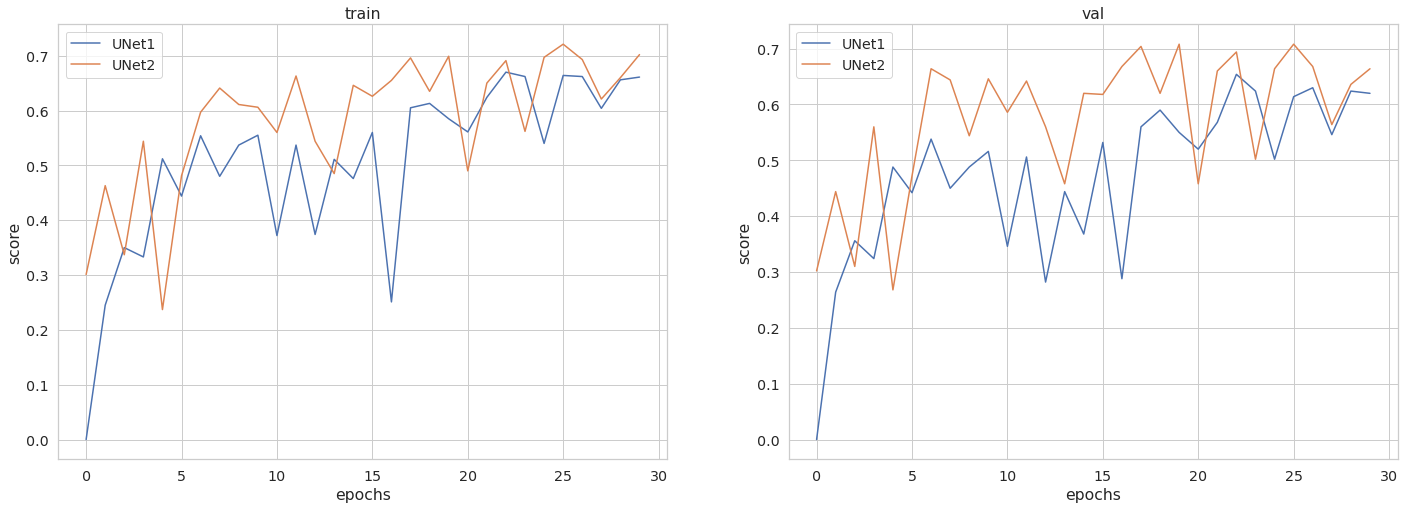

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(1,2, figsize=(24, 8))

ax[0].plot(score_unet, label="UNet1")
ax[0].plot(score_unet2, label="UNet2")
ax[0].set(title = 'train')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(val_score_unet, label="UNet1")
ax[1].plot(val_score_unet2, label="UNet2")
ax[1].set(title = 'val')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("score")
ax[1].legend()

plt.show()

Видим, что UNet2 обучилась лучше, чем UNet1. Отсюда следует закономерный вывод: использование конфигурации, где max-pooling заменен на convolution с stride=2, 
а upsampling заменен на transpose-convolutions с stride=2, позволяет обучать сеть быстрее и лучше.

## Итог по работе

1. Разобраны различные функции ошибки и архитектуры сетей SegNet и UNet. Написаны их реализации в коде.

2. Исследованы различные сегментационные лоссы. Одинаковая модель SegNet обучалась на различных функциях ошибки, в результате чего был получен эмпирический результат: лучшим из 4 рассмотренных лоссов оказался Dice-loss.

3. Выполнено сравнение двух различных парадигм написания сети для сегментации. Первая - использование maxpool для down-sampling и maxunpool для up-sampling. Вторая - использование convoluation(stride=2) для down-sampling и transpose convoluation для up-sampling. Обе были имплементированы в UNet. Лучший результат показала вторая парадигма.

4. Проведено сравнение SegNet и UNet при использовании одинаковой функции ошибки - Dice-loss. По итогам обучения эти модели показали примерно одинаковые результаты. Я ожидал, что благодаря skip-connection UNet покажет лучший результат, однако такого не случилось. Вероятно, она смогла бы достичь бОльшего score, если продолжить ее обучать, но это слишном долго, поэтому в этом аспекте я выдвигаю лишь гипотезу.
